In [1]:
#!/usr/bin/env python

from collections import deque
import time
import random
import os

import numpy as np
import cv2
import gym
import h5py

# ROS packages required
import rospy
import rospkg

from keras.models import load_model

from neuroracer_gym.tasks import neuroracer_discrete_task

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [ ]:
rospy.init_node('neuroracer_qlearn', anonymous=True, log_level=rospy.INFO)
NeuroRacer(Agent, 100).run()

In [ ]:
a1 = np.array(range(20))/2.0
a2 = np.empty(20)
a2.fill(1.7)
a2 = np.power(a2, a1)
a1=a1**2
a1
plt.plot((a1), label='a1')

plt.plot((a2), label='a2')
plt.legend()
print(a2-1)

In [ ]:
rospy.init_node('neuroracer_qlearn', anonymous=True, log_level=rospy.INFO)
env = gym.make('NeuroRacer-v0')

In [ ]:
env.initial_position = {'p_x': np.random.uniform(1,4), 'p_y': 3.7, 'p_z': 0.05, 'o_x': 0, 'o_y': 0.0, 'o_z': np.random.uniform(0.4,1), 'o_w': 0.855}
# env.initial_position = None
state = env.reset()



In [ ]:
rd = np.clip(ranges[170:180].mean(), None, 10)
ld = np.clip(ranges[910:920].mean(), None, 10)
print(ld,rd)

In [ ]:
np.clip(ranges[525:535].mean(), None, 10)

In [2]:
img_y_offset = 200
img_y_scale = 0.2
img_x_scale = 0.2

class PolarRay:
    def __init__(self, n_rays, min_angle, max_angle):
        self.min_a = min_angle
        self.max_a = max_angle
        self.n = n_rays
        self.l = np.abs(min_angle) + np.abs(max_angle)
        self.lh = self.l/2
        
    def ray_to_rad(self, ray_idx):
        return (self.lh-ray_idx*self.l/self.n)

    def ray_to_degree(self, ray_idx):
        return self.ray_to_rad(ray_idx)*180/np.pi

    def degree_to_ray(self, degree):
        return np.round((self.lh - degree*np.pi/180.0)*self.n/self.l).astype(np.int32)

<BarContainer object of 1 artists>

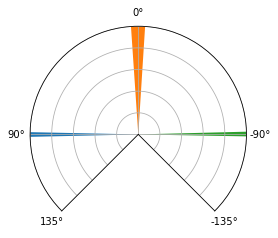

In [26]:
pr = PolarRay(1081, -2.3561944902, 2.3561944902)


fig = plt.figure()
plt1 = fig.add_subplot(1,1,1, polar=True)

plt1.set_yticklabels([])
plt1.set_ylim(0, 1)
plt1.set_thetamin(pr.min_a*180/np.pi)
plt1.set_thetamax(pr.max_a*180/np.pi)
plt1.set_theta_offset(np.pi/2)
plt1.set_xticks([pr.max_a, 90*np.pi/180, 0, -90*np.pi/180, pr.min_a])

r = pr.ray_to_rad(180) 
rw = pr.ray_to_rad(185)-pr.ray_to_rad(175)

c = pr.ray_to_rad(540)
cw = pr.ray_to_rad(555)-pr.ray_to_rad(525)

l = pr.ray_to_rad(900)
lw = pr.ray_to_rad(905)-pr.ray_to_rad(895)

# ax.plot(np.full(2,ray_to_rad(180, 1081, -2.3561944902, 2.356194490)),y)
plt1.bar([r],[1], width=rw)
plt1.bar([c],[1], width=cw)
plt1.bar([l],[1], width=lw)

In [27]:
pr.degree_to_ray(-90)

901

In [ ]:
img = env.reset()
states = deque(maxlen=4)
for i in range(4):
    states.append(preprocess(img))


In [ ]:
model = load_model('model_0.h5')
# model = load_model('neuroracer.h5')

In [ ]:
img = env.reset()
states = deque(maxlen=4)
for i in range(4):
    states.append(preprocess(img))
done = False
trail=0
while trail<3:
    action = np.argmax(model.predict(np.expand_dims(np.stack(states, axis=2), axis=0))[0])
    img, reward, done, _ = env.step(action)
    states.append(preprocess(img))
    if done:
        trail+=1
        done = False
        img = env.reset()
        for i in range(4):
            states.append( preprocess(img))

In [ ]:
# env.set_sleep_rate(100)
# env.number_of_sleeps = 10
# env.speed = 1

# img = env.reset()
# plt.figure()
# plt.imshow(img)

# for i in range(10):
img, reward, done, _ = env.step(1)

states = deque(maxlen=4)

plt.figure()
src = cv2.cvtColor(img[200:,:], cv2.COLOR_RGB2GRAY)
img1 = cv2.resize(src, None, fx = 0.2, fy = 0.2, interpolation = cv2.INTER_LINEAR )
plt.imshow(img1, cmap='gray')
states.append(img1)

img, reward, done, _ = env.step(1)
img, reward, done, _ = env.step(1)
img, reward, done, _ = env.step(1)
img, reward, done, _ = env.step(1)
plt.figure()
src = cv2.cvtColor(img[200:,:], cv2.COLOR_RGB2GRAY)
img1 = cv2.resize(src, None, fx = 0.2, fy = 0.2, interpolation = cv2.INTER_LINEAR )
plt.imshow(img1, cmap='gray')
states.append(img1)

img, reward, done, _ = env.step(1)
img, reward, done, _ = env.step(1)
img, reward, done, _ = env.step(1)
img, reward, done, _ = env.step(1)
plt.figure()
src = cv2.cvtColor(img[200:,:], cv2.COLOR_RGB2GRAY)
img1 = cv2.resize(src, None, fx = 0.2, fy = 0.2, interpolation = cv2.INTER_LINEAR )
states.append(img1)

plt.imshow(img1, cmap='gray')
img, reward, done, _ = env.step(1)
img, reward, done, _ = env.step(1)
img, reward, done, _ = env.step(1)
img, reward, done, _ = env.step(1)
plt.figure()
src = cv2.cvtColor(img[200:,:], cv2.COLOR_RGB2GRAY)
img1 = cv2.resize(src, None, fx = 0.2, fy = 0.2, interpolation = cv2.INTER_LINEAR )
states.append(img1)

plt.imshow(img1, cmap='gray')
img, reward, done, _ = env.step(1)
img, reward, done, _ = env.step(1)
img, reward, done, _ = env.step(1)
img, reward, done, _ = env.step(1)
plt.figure()
src = cv2.cvtColor(img[200:,:], cv2.COLOR_RGB2GRAY)
img1 = cv2.resize(src, None, fx = 0.2, fy = 0.2, interpolation = cv2.INTER_LINEAR )
plt.imshow(img1, cmap='gray')
states.append(img1)

In [ ]:
states_stacked = np.stack(states, axis=2)
# states_stacked.shape
# ssa = np.expand_dims()

# actions, s, ns, rewards, terminates = memory.sample(6)
# s.shape

In [ ]:
plt.imshow(np.flip(states_stacked, axis=1)[:,:,0], cmap='gray')

In [ ]:
src = cv2.cvtColor(img[200:,:], cv2.COLOR_RGB2GRAY)
img1 = cv2.resize(src, None, fx = 0.2, fy = 0.2, interpolation = cv2.INTER_LINEAR )
plt.imshow(img1, cmap='gray')

In [ ]:
next_state = deque(maxlen=4)
next_state.append(img1)
next_state.append(img1)
next_state.append(img1)
next_state.append(img1)

In [ ]:
test_state = deque(maxlen=10)
test_state.append((np.stack(next_state, axis=2)))
test_state.append((np.stack(next_state, axis=2)))                 
test_state.append((np.stack(next_state, axis=2)))                 
test_state.append((np.stack(next_state, axis=2)))                 
test_state.append((np.stack(next_state, axis=2)))                 
test_state.append((np.stack(next_state, axis=2)))
np.array(test_state, dtype=np.float32).shape


In [ ]:
sample_batch_size = 6
actions, states, next_states, rewards, terminates = memory.sample(sample_batch_size)
not_done = np.invert(terminates)
not_done_pred = model.predict(next_states[not_done]).max(axis=1)
rewards[not_done]+= 0.9 * not_done_pred
target = model.predict(states)
target[np.arange(sample_batch_size), actions] = rewards

In [ ]:
a = np.argmax(model.predict(np.expand_dims(np.stack(next_state, axis=2), axis=0))[0])
print(a)
img, reward, done, _ = env.step(a)

src = cv2.cvtColor(img[200:,:], cv2.COLOR_RGB2GRAY)
img1 = cv2.resize(src, None, fx = 0.2, fy = 0.2, interpolation = cv2.INTER_LINEAR )
next_state.append(img1)
plt.imshow(img1, cmap='gray')

In [ ]:
plt.figure()
plt.imshow(np.stack(next_state, axis=2)[:,:,0], cmap='gray')
plt.figure()
plt.imshow(np.stack(next_state, axis=2)[:,:,1], cmap='gray')
plt.figure()
plt.imshow(np.stack(next_state, axis=2)[:,:,2], cmap='gray')
plt.figure()
plt.imshow(np.stack(next_state, axis=2)[:,:,3], cmap='gray')

In [ ]:
b = deque(maxlen=4)
b.append(img1)
b.append(img1)
b.append(img1)
b.append(img1)

h = np.expand_dims(np.stack(b, axis=2), axis=0)

In [ ]:
# import h5py
import numpy as np
import random

In [ ]:
for i in np.random.choice([1], 2, False):
    print(i)

In [ ]:
m1 = H5Buffer((2,),10)
m1.append(np.array([1,2,3,4,5,6]))
m1.actions[:]

In [ ]:
m1.append(np.array([0, 1,2,3,4,5,6,7,8]))
m1.actions[:]

In [ ]:
m1.sample(0,m1.length())

In [ ]:
m1.close()

In [ ]:
img = preprocess(env.reset())
states = deque(maxlen=4)
for i in range(4):
    states.append(img)
    
data = np.stack(states, axis=2)
memory.append(0,data,data, 1.0, False)
memory.append(1,data,data, 2.0, True)              
memory.append(2,data,data, 3.0, True)              
memory.append(0,data,data, 4.0, False)              
memory.append(1,data,data, 5.0, True)              
memory.append(2,data,data, 6.0, False)              
memory.append(0,data,data, 7.0, True)              
memory.append(1,data,data, 8.0, False)              
memory.append(2,data,data, 9.0, True)              
memory.append(0,data,data, 10.0, True)              
memory.append(1,data,data, 11.0, False)              

In [ ]:
actions, states, next_states, rewards, terminates = memory.sample(4)

In [ ]:
np.concatenate((states,next_states)).shape

In [ ]:
print(actions)
print(2-actions)

In [ ]:
rewards[np.invert(terminates)]+= 1 + actions[np.invert(terminates)]

In [ ]:
print(states.shape)
flipped = np.flip(states, axis=2)
plt.figure()
plt.imshow(states[0,:,:,0], cmap='gray')
plt.figure()
plt.imshow(flipped[0,:,:,0], cmap='gray')

In [ ]:
i = 0
while True:
    i+=1
    next_state, reward, done, _ = env.step(1)
    if done:
        print(i)
        i = 0
        env.reset()
# plt.imshow(next_state)


In [ ]:
print(degree_to_ray(np.array([-90, 90]), 1081, -2.3561944902, 2.3561944902))
print(ray_to_degree(180, 1081, -2.3561944902, 2.356194490))
print(ray_to_rad(180, 1081, -2.3561944902, 2.356194490))
ray_to_rad(175, 1081, -2.3561944902, 2.356194490)-ray_to_rad(185, 1081, -2.3561944902, 2.356194490)

In [ ]:
np.full(2,1)